# Tests for the GNN refinements

This script provides some example scripts for the refinement of graphs.

In [14]:
import torch
import torch_geometric
from torch_geometric.data import DataLoader, Batch, Data
import networkx as nx
import itertools

from IPython.display import Image
from os import chdir
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt


to_undirected = torch_geometric.transforms.ToUndirected()


### Generating example dataset

In [15]:
x = torch.tensor([[-1,0],[1,0],[0,1],[0,-1]])
edge_index = torch.tensor([[0,1],[1,2],[2,3],[0,3],[0,2]]).T

data = Data(x=x, edge_index=edge_index)
print(data.edge_index)

to_undirected(data)

tensor([[0, 1, 2, 0, 0],
        [1, 2, 3, 3, 2]])


Data(x=[4, 2], edge_index=[2, 10])

In [18]:
st = gd.SimplexTree()
for edge in edge_index.T:
    st.insert(edge.tolist())



print(list(st.get_filtration()))

[([0], 0.13), ([1], 0.13), ([0, 1], 0.13), ([2], 0.13), ([0, 2], 0.13), ([1, 2], 0.13), ([3], 0.13), ([0, 3], 0.13), ([2, 3], 0.13)]


In [4]:
# https://stackoverflow.com/questions/28095646/finding-all-paths-walks-of-given-length-in-a-networkx-graph

G = torch_geometric.utils.to_networkx(data, to_undirected=True)

def findPaths(G,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in G.neighbors(u) for path in findPaths(G,neighbor,n-1) if u not in path]
    return paths

def get_paths_length_k(G,k):
    allpaths = []
    for node in G:
        allpaths.extend(findPaths(G,node,k))

    paths = []
    # Remove reverse path is in the set [0,1,2]==[2,1,0]
    for idx, path in enumerate(allpaths): 
        if path[::-1] not in paths: 
            paths.append(path)
    return paths

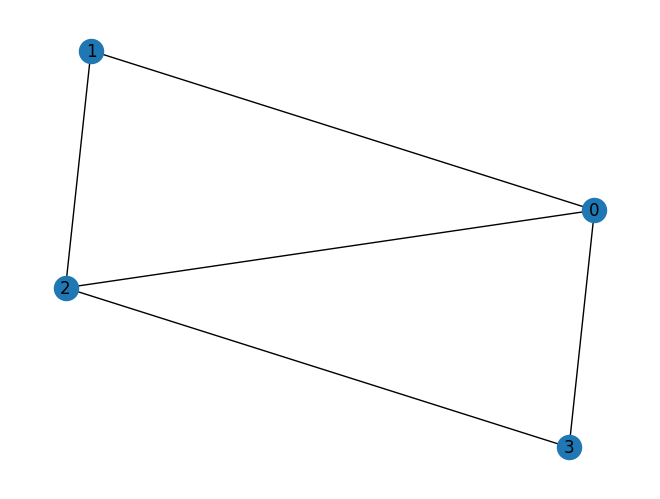

In [6]:
# First cast to undirected graph
g = torch_geometric.utils.to_networkx(to_undirected(data), to_undirected=True)
nx.draw(g, with_labels=True)

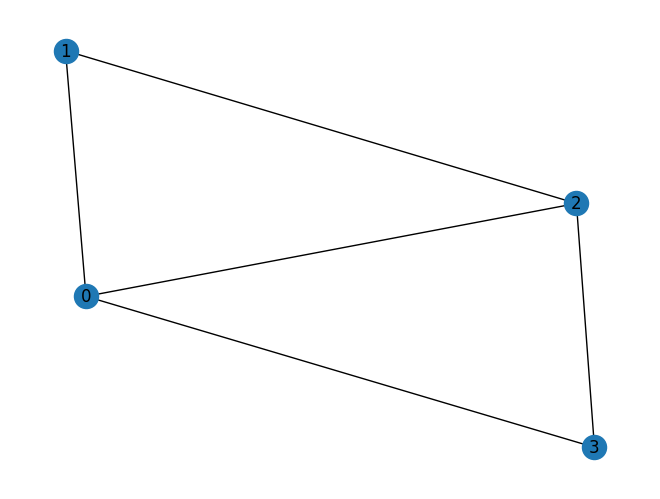

In [7]:
# First cast to undirected graph
g = torch_geometric.utils.to_networkx(to_undirected(data), to_undirected=True)
nx.draw(g, with_labels=True)

In [26]:
# Create new node for each different path and link them to the original nodes
def update_graph(paths, nodes_dict, edge_index, path_length = 1):
    num_nodes = len(nodes_dict)
    for path in paths:
        nodes_dict[tuple(path.tolist())] = num_nodes
                
        p_length = path_length
        
        end_nodes_l = []
        while p_length>0:

            for i, j in itertools.combinations(range(len(path) + 1), 2):
                node = tuple(path.tolist()[i:j])
                #print(stuff[i:j])

            #end_nodes_ = itertools.combinations(path.tolist(), p_length)
            #for node in end_nodes_:
                end_nodes_l.append(nodes_dict[node])
            p_length -= 1

        source_nodes = torch.Tensor([num_nodes]).repeat(len(end_nodes_l)).long()
        
        new_edges_0 = torch.stack([source_nodes, torch.Tensor(end_nodes_l).long()],0)
        new_edges_1 = torch.stack([torch.Tensor(end_nodes_l).long(), source_nodes],0)
        new_edges = torch.cat([new_edges_0, new_edges_1],1)
        
        edge_index = torch.cat([edge_index, new_edges],1)
        num_nodes += 1
    return edge_index, nodes_dict

In [27]:
# Example

edge_index = data.edge_index # Getting the edge index of the graph

A = torch_geometric.utils.to_dense_adj(data.edge_index)[0] # Creates adjacency matrix

nodes_dict = {(i,): i for i in range(A.shape[0])} # Dictionary to keep track of the nodes

paths = get_paths_length_k(A, 1) # Get all the paths of length 2
edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 1) # Append these paths to the graph

paths = get_paths_length_k(A, 2) # Get all the paths of length 2
edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 2) # Append these paths to the graph

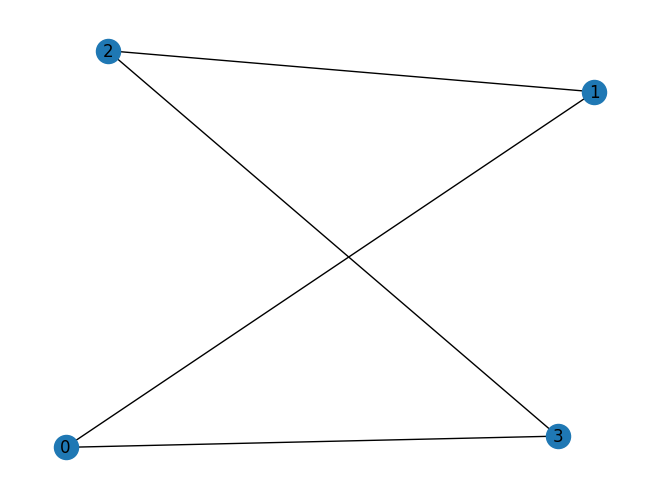

In [28]:
import networkx as nx

g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, with_labels=True)

In [29]:
nodes_dict

{(0,): 0,
 (1,): 1,
 (2,): 2,
 (3,): 3,
 (0, 1): 4,
 (0, 3): 5,
 (1, 2): 6,
 (2, 3): 7,
 (0, 1, 2): 8,
 (1, 2, 3): 9}

In [21]:
# Initialize all nodes with the same color

# Scratch pad

In [19]:
def path_transform(data):
    edge_index = data.edge_index # Getting the edge index of the graph

    A = torch_geometric.utils.to_dense_adj(data.edge_index)[0] # Creates adjacency matrix

    nodes_dict = {(i,): i for i in range(A.shape[0])} # Dictionary to keep track of the nodes

    paths = get_paths_length_k(A, 1) # Get all the paths of length 2
    edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 1) # Append these paths to the graph

    paths = get_paths_length_k(A, 2) # Get all the paths of length 2
    edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 2) # Append these paths to the graph

    data.x = torch.zeros((len(nodes_dict), 4))
    data.edge_index = edge_index_updated
    return data

In [146]:
class GeoDataPL(pl.LightningDataModule):
    def __init__(self, name, batch_size, num_workers = 0):
        super().__init__()
        self.name = name
        self.batch_size = batch_size
        self.num_workers = num_workers
 
    def setup(self, stage = None):

        ds = TUDataset(root = "../data/", name = self.name, pre_transform= path_transform)

        train_idx, test_idx = train_test_split(list(range(len(ds))), test_size = 0.2)
        train_idx, val_idx = train_test_split(list(range(len(ds))), test_size = 0.2) 

        self.train_ds = Subset(ds,train_idx)
        self.val_ds = Subset(ds,val_idx)
        self.test_ds = Subset(ds,test_idx)

        self.num_classes = len(torch.unique(ds._data.y))

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size = self.batch_size, num_workers = self.num_workers, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size = self.batch_size, num_workers = self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size = self.batch_size, num_workers = self.num_workers)



In [148]:
# PL MOdel

class GNNModel(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super().__init__()
        self.num_classes = num_classes
        self.lr = lr
        self.model = torch_geometric.nn.GCNConv(4, num_classes)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x, edge_index):
        return self.model(x, edge_index)
    
    def training_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("test_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr)
    
    def predict(self, x, edge_index):
        return self(x, edge_index)
    


In [150]:
dl = GeoDataPL("MUTAG", 32, 0)
dl.setup()
num_classes = dl.num_classes

mod = GNNModel(num_classes= num_classes, lr = 0.001 )

In [152]:
trainer = pl.Trainer(max_epochs = 10)
trainer.fit(mod, dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | GCNConv          | 10    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
10        Trainable params
0         Non-trainable params
1

Sanity Checking: 0it [00:00, ?it/s]

/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


ValueError: Expected input batch_size (4986) to match target batch_size (32).

# WIP

In [73]:
A2 = torch.einsum('ij,jk->ijk', A, A)
A3 = torch.einsum('ijk,kl->ijkl', A2, A)
A4 = torch.einsum('ijkl,lm->ijklm', A3, A)
A5 = torch.einsum('ijklm,mn->ijklmn', A4, A)

In [88]:
.shape

torch.Size([65, 3])

In [77]:
A.sum()

tensor(22.)

tensor(0.)

In [19]:
from torch_geometric.nn import MessagePassing

In [ ]:
class AggGraphClass(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))

        self.node_emb = nn.Sequential(nn.Linear(out_channels,out_channels),nn.ReLU())

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        ## Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return self.node_emb(x_j)
    
    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out